
# Impact of news on the Bitcoin price

    @version: 0.1.2
    @description: This notebook will read Bitcoin price values and transaction volumes
    from CSV files and display a figure showing the relationship between the two.

This analysis **(a work in progress)** is an attempt to find a corollation between bitcoin related news and the rise or fall of the bitcoin exchange rate (BTC/USD).

Note: http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-4-Matplotlib.ipynb

###DATA
####Get the Bitcoin (Sample) Data
Download all the bitcoin price historical data. This can be found in http://api.bitcoincharts.com/v1/csv/
In order to get all the available data from all markets, execute the following:

    wget -A csv.gz -r -l 1 -nd http://api.bitcoincharts.com/v1/csv/
    
From this entire bitcoincharts repo, the most comprehensive catalog of data is `btceUSD.csv`.

For the purposes of this excercise, i'm using a small data sample `b7USD.csv`.

For the Bitcoin Transactions Volume (in BTC or USD) you can get this data from Quandl through their API

    http://www.quandl.com/api/v1/datasets/BCHAIN/ETRAV.csv (BTC)
    http://www.quandl.com/api/v1/datasets/BCHAIN/ETRVU.csv (USD)

####Unzip the package

    $: gunzip btceUSD.csv.gz


In [121]:
# Import the necessary shit
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as dates

mpl.rc('figure', figsize=(8, 7))

# Enable inline plotting
%matplotlib inline

In [122]:
# Loading the Bitcoin PRICE data
# Format:
# EPOCH_TIMESTAMP, PRICE_VALUE, NO_FUCKING_CLUE
data_location = r'_raw_data/b7USD.csv'
# reading the CSV file while specifying headers (with the param names), 
# because there aren't any in those csv files
raw_price_data = pd.read_csv(data_location, names=['TimeStamp', 'Price', 'RandV'])

# Loading Bitcoin Transactions Volume Data (in BTC)
data_location = r'_raw_data/trans_volumes/BCHAIN-ETRAV.csv'
raw_trans_vol = pd.read_csv(data_location)

# Loading Bitcoin Transactions Volume Data (in USD)
data_location = r'_raw_data/trans_volumes/BCHAIN-ETRVUSD.csv'
raw_trans_usd_vol = pd.read_csv(data_location)

In [123]:
raw_price_data.count()

TimeStamp    5492
Price        5492
RandV        5492
dtype: int64

In [124]:
raw_trans_vol.count()

Date     2269
Value    2269
dtype: int64

In [125]:
raw_trans_usd_vol.count()

Date     2269
Value    2269
dtype: int64

In [126]:
#===========================
# CLEAN PRICE DATA
#===========================

# Add a new column DateTime that contains
# formatted date/time based on the Epoch 
# TimeStamp provided in the data set
# raw_data['DateTime'] = raw_data['TimeStamp'].apply(lambda x: time.strftime('%d-%m-%Y %H:%M:%S',  time.gmtime(x)))

# Another more efficient way of doing the 
# Timestamp to formatted date conversion
# unit='s' is to specify that the timestamp 
# was stored with the seconds unit
raw_price_data['Date'] = pd.to_datetime(raw_price_data['TimeStamp'], unit='s')

# Reset time to 00:00:00 useful in the next segment
# to remove all prices within a given day and leave 
# the last price value
raw_price_data['Date'] = raw_price_data['Date'].apply(pd.datetools.normalize_date)

# Keep last value only for each day (remove all other duplicates)
# The search for duplicates is done on the Date column
# inplace instructs the kernel not to create a copy
raw_price_data.drop_duplicates('Date', take_last=1, inplace=1)

# Creating a DataFrame from the Bitcoin price raw data
btc_df = pd.DataFrame(raw_price_data, columns=['Date', 'Price'])

btc_df.tail()

,Date,Price
5414,2011-10-01,5.00
5439,2011-10-02,5.00
5459,2011-10-03,4.99
5480,2011-10-04,4.99
5491,2011-10-05,4.75


In [127]:
#============================
# CLEAN TRANS VOLUME BTC DATA
#============================

# Sort all the data now by DESC order
# raw_price_data.sort('Date', ascending=1, inplace=1)

# Change the Date column type from object(default)
# to datetime
raw_trans_vol['Date'] = pd.to_datetime(raw_trans_vol['Date'])

# Sort all the data now by DESC order
raw_trans_vol.sort('Date', ascending=1, inplace=1)

# Create a DataFrame from Trans Volume (in BTC) raw data
trans_volBTC_df = pd.DataFrame(raw_trans_vol, columns=['Date', 'Value'])

# Change column names to Date, Volume
trans_volBTC_df.columns = ['Date', 'Volume']

trans_volBTC_df.tail()

,Date,Volume
4,2015-03-17,165657
3,2015-03-18,226782
2,2015-03-19,231736
1,2015-03-20,180944
0,2015-03-21,135631


In [128]:
#============================
# CLEAN TRANS VOLUME USD DATA
#============================

# Sort all the data now by DESC order
# raw_price_data.sort('Date', ascending=1, inplace=1)

# Change the Date column type from object(default)
# to datetime
raw_trans_usd_vol['Date'] = pd.to_datetime(raw_trans_usd_vol['Date'])

# Sort all the data now by DESC order
raw_trans_usd_vol.sort('Date', ascending=1, inplace=1)

# Create a DataFrame from Trans Volume (in USD) raw data
trans_volUSD_df = pd.DataFrame(raw_trans_usd_vol, columns=['Date', 'Value'])

# Change column names to Date, Volume
trans_volUSD_df.columns = ['Date', 'Volume']

trans_volUSD_df.head()

,Date,Volume
2268,2009-01-03,0
2267,2009-01-04,0
2266,2009-01-05,0
2265,2009-01-06,0
2264,2009-01-07,0


In [129]:
#============================
# MERGE ALL DATA 
#============================

btc_df = pd.merge(btc_df, trans_volBTC_df, how='left', on='Date',sort=True)
btc_df = pd.merge(btc_df, trans_volUSD_df, how='left', on='Date',sort=True, suffixes=['_BTC', '_USD'])

In [130]:
btc_df = btc_df.set_index('Date')
btc_df.head()

,Price,Volume_BTC,Volume_USD
Date,,,
2011-06-14,18.87,298363,6262642
2011-06-15,19.01,122562,2451236
2011-06-16,18.01,132251,2639725
2011-06-17,14.00,152927,2965232
2011-06-18,30.00,116204,1998701


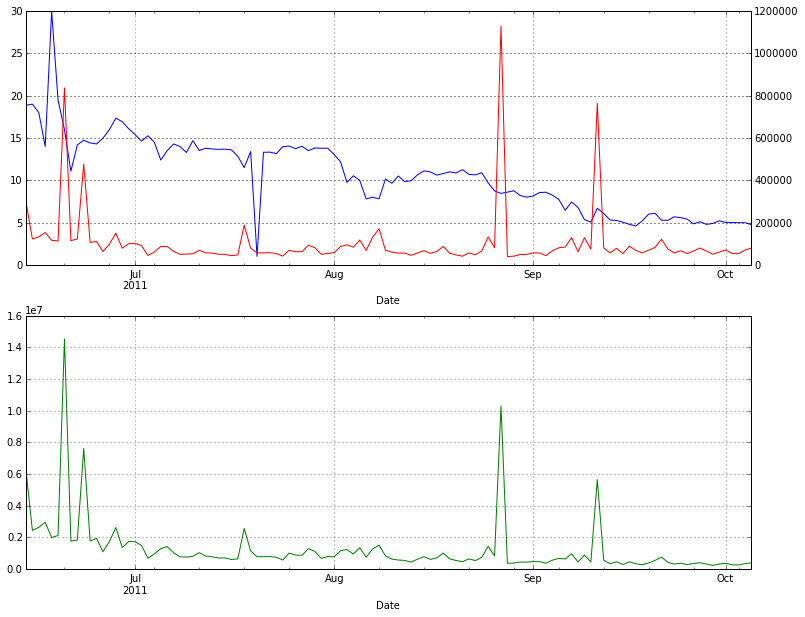

In [131]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(211)
ax2 = ax.twinx()
ax3 = fig.add_subplot(212, sharex=ax)

btc_df.Price.plot(ax=ax, label="Price", style='b-')
btc_df.Volume_BTC.plot(ax=ax2, label="Volume_BTC", style='r-')
btc_df.Volume_USD.plot(ax=ax3, label="Volume_USD", style='g-')

plt.show()